## Guided Regularized Random Forest (GRRF) classification example
This notebook shows and explains how to optimize and run GRRF (R toolbox) in a classification example. The Demo uses the Salinas image downloaded from http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes in matlab format. 
+ **Last version finished:** 27/08/2021
+ **Authors:** *Emma Izquierdo-Verdiguier* and *Raul Zurita-Milla*

In [1]:
import os
import random
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import rcParams

from Tools import diff
from Tools import prediction 
from Tools import split_data
from Tools import RandomForestFI
from Tools import ind_VfoldCross
from Tools import GRRFoptimization
from Tools import classificationMap
from Tools import SelectedGRRFfeatures
from Tools import plot_confusion_matrix

In [2]:
random.seed(9001)
Niter = 2
Ntrain = 100
Nval = 50

## Step 1: Load Salinas database.

In [3]:
image = 'Salinas'
Image = sio.loadmat(r'.\data' + os.sep + image + '_corrected.mat')
Image_gt = sio.loadmat(r'.\data' + os.sep + image + '_gt.mat')
Rootoutput = r'.\results' 

X_total = Image.get('salinas_corrected')
Y_total = Image_gt.get('salinas_gt')
[nr, nc, nb] = X_total.shape

In [4]:
X_total = X_total.reshape((nr * nc, nb))
Y_total = Y_total.reshape((nr * nc, 1))
X = X_total[np.where(Y_total != 0)[0], :]
Y = Y_total[np.where(Y_total != 0)[0]]

Define the name of the classes and the features:

In [5]:
classes_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
wavelength = [0.4000, 0.4094, 0.4188, 0.4283, 0.4377, 0.4471, 0.4565, 0.4659, 0.4753, 0.4848, 0.4942, 0.5036,
              0.5130, 0.5224, 0.5318, 0.5413,
              0.5507, 0.5601, 0.5695, 0.5789, 0.5883, 0.5978, 0.6072, 0.6166, 0.6260, 0.6354, 0.6448, 0.6543,
              0.6637, 0.6731, 0.6825, 0.6919,
              0.7013, 0.7108, 0.7202, 0.7296, 0.7390, 0.7484, 0.7578, 0.7673, 0.7767, 0.7861, 0.7955, 0.8049,
              0.8143, 0.8238, 0.8332, 0.8426,
              0.8520, 0.8614, 0.8709, 0.8803, 0.8897, 0.8991, 0.9085, 0.9179, 0.9274, 0.9368, 0.9462, 0.9556,
              0.9650, 0.9744, 0.9839, 0.9933,
              1.0027, 1.0121, 1.0215, 1.0309, 1.0404, 1.0498, 1.0592, 1.0686, 1.0780, 1.0874, 1.0969, 1.1063,
              1.1157, 1.1251, 1.1345, 1.1439,
              1.1534, 1.1628, 1.1722, 1.1816, 1.1910, 1.2004, 1.2099, 1.2193, 1.2287, 1.2381, 1.2475, 1.2570,
              1.2664, 1.2758, 1.2852, 1.2946,
              1.3040, 1.3135, 1.3229, 1.3323, 1.3417, 1.3511, 1.3605, 1.3700, 1.3794, 1.3888, 1.3982, 1.4547,
              1.4641, 1.4735, 1.4830, 1.4924,
              1.5018, 1.5112, 1.5206, 1.5300, 1.5395, 1.5489, 1.5583, 1.5677, 1.5771, 1.5865, 1.5960, 1.6054,
              1.6148, 1.6242, 1.6336, 1.6430,
              1.6525, 1.6619, 1.6713, 1.6807, 1.6901, 1.6996, 1.7090, 1.7184, 1.7278, 1.7372, 1.7466, 1.7561,
              1.7655, 1.7749, 1.7843, 1.7937,
              1.8031, 1.8126, 1.8220, 1.8314, 1.9726, 1.9821, 1.9915, 2.0009, 2.0103, 2.0197, 2.0291, 2.0386,
              2.0480, 2.0574, 2.0668, 2.0762,
              2.0857, 2.0951, 2.1045, 2.1139, 2.1233, 2.1327, 2.1422, 2.1516, 2.1610, 2.1704, 2.1798, 2.1892,
              2.1987, 2.2081, 2.2175, 2.2269,
              2.2363, 2.2457, 2.2552, 2.2646, 2.2740, 2.2834, 2.2928, 2.3022, 2.3117, 2.3211, 2.3305, 2.3399,
              2.3493, 2.3587, 2.3682, 2.3776,
              2.3870, 2.3964, 2.4058, 2.4152, 2.4247, 2.4341, 2.4435, 2.4529, 2.4623, 2.4717, 2.4812, 2.4906]

BandNames = np.array([str(wavelength[i]) for i in range(0, nb)])

## Step 2: Split the database in train, validation and test.

In [6]:
[X_train, Y_train, X_val, Y_val, X_test, Y_test] = split_data(X, Y, Ntrain, Nval)

## Step 3: Calculate the FI of the features from RF classifier

In [7]:
[rf, importRF_all, indicesRF] = RandomForestFI(X_train, Y_train)

RF done!
time of RF using all features:  0.6095261573791504


## Step 4: Look for the best GRRF parameters

In [8]:
lambdas = [0.3, 0.4]
gammas = [0.4, 0.5]

GRRFparameters = GRRFoptimization(lambdas, gammas, importRF_all, indicesRF, X_train, Y_train, X_val, Y_val, Niter)

['gamma: 0.4 and lambda 0.3 select 3 features: GRRF OA= 84.125 and RFsel OA= 73.5']
['gamma: 0.4 and lambda 0.3 select 3 features: GRRF OA= 84.875 and RFsel OA= 72.875']
['gamma: 0.5 and lambda 0.3 select 4 features: GRRF OA= 83.625 and RFsel OA= 72.875']
['gamma: 0.5 and lambda 0.3 select 4 features: GRRF OA= 83.5 and RFsel OA= 73.375']
['gamma: 0.4 and lambda 0.4 select 4 features: GRRF OA= 81.5 and RFsel OA= 73.375']
['gamma: 0.4 and lambda 0.4 select 4 features: GRRF OA= 81.25 and RFsel OA= 74.125']
['gamma: 0.5 and lambda 0.4 select 7 features: GRRF OA= 77.25 and RFsel OA= 75.5']
['gamma: 0.5 and lambda 0.4 select 7 features: GRRF OA= 76.75 and RFsel OA= 76.0']


In [9]:
OA = []
for i in GRRFparameters:
    OA.append(i[2])

ind_max = np.argmax(OA, axis=None)
BestGamma = GRRFparameters[ind_max][0]
BestLambda = GRRFparameters[ind_max][1]
print(['Best GRRF parameters: Best gamma = ' + str(BestGamma) + ' and best lambda = ' + str(BestLambda)])


['Best GRRF parameters: Best gamma = 0.4 and best lambda = 0.3']


## Step 5: Look for the selected features.

In [10]:
[indices, importances, selected_features] = SelectedGRRFfeatures(BestGamma, BestLambda, importRF_all, X_train, Y_train, 
                                                                 X_val, Y_val)

BandNames_Selec = BandNames[selected_features]
print([ str(len(selected_features)) + ' features selected by GRRF.'])

['3 features selected by GRRF.']


#### Plot the best selected features (max. 10 features) 

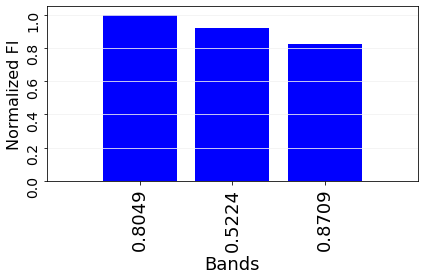

In [11]:
rcParams.update({'figure.autolayout': True})
plt.ioff()
bands = np.min([10, len(indices)])

plt.bar(np.array(range(bands)).astype('float64'), importances[indices[0:bands]].ravel(), color="b",
        align="center")
plt.grid(axis='y', color='0.95')
plt.ylabel('Normalized FI', fontsize=16)
plt.xlabel("Bands", fontsize=18)
plt.yticks(np.linspace(0, 1, 6), np.round(np.linspace(0, 1, 6), 2), rotation='vertical', fontsize=14)
plt.xticks(range(bands), BandNames_Selec[indices[0:bands]], rotation='vertical', fontsize=18)
plt.xlim([-1, bands])
plt.show()
plt.savefig(Rootoutput + os.path.sep + 'FeatSelect_GRRF' + '.eps', format='eps', dpi=1000)

## Step 6: Results

##### GRRF feature selection

In [12]:
[final_grrf, OA_GRRF, CM_GRRF, k, CR]= prediction(X_train, Y_train, X_test, Y_test, classes_names, selected_features)

Overall Accuracy of GRRF: 80.37%
Confusion matrix


<Figure size 432x288 with 0 Axes>

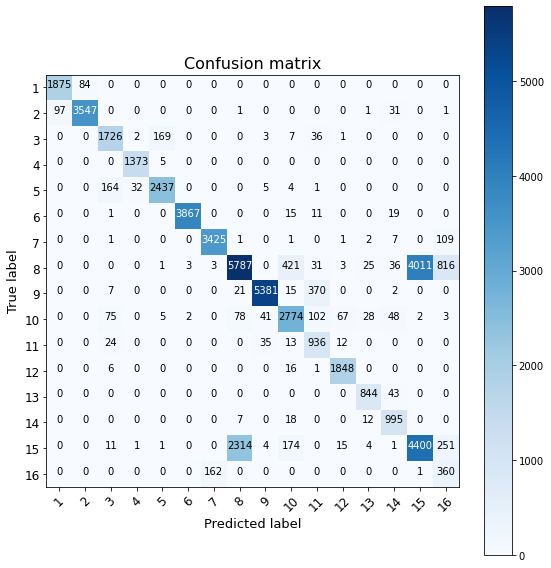

In [13]:
print('Overall Accuracy of GRRF: ' + "%.2f"  % (OA_GRRF*100) + '%')
plt.rcParams['figure.figsize'] = [8, 8]
f = plt.figure()
plot_confusion_matrix(CM_GRRF, classes_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)
plt.show()

##### RF feature selection

In [14]:
sel_RF = indicesRF[0:len(indices)]
[final_rf, OA_RF, CM_RF, k, CR]= prediction(X_train, Y_train, X_test, Y_test, classes_names, sel_RF)

Overall Accuracy of RF with selected features: 73.32%
Confusion matrix


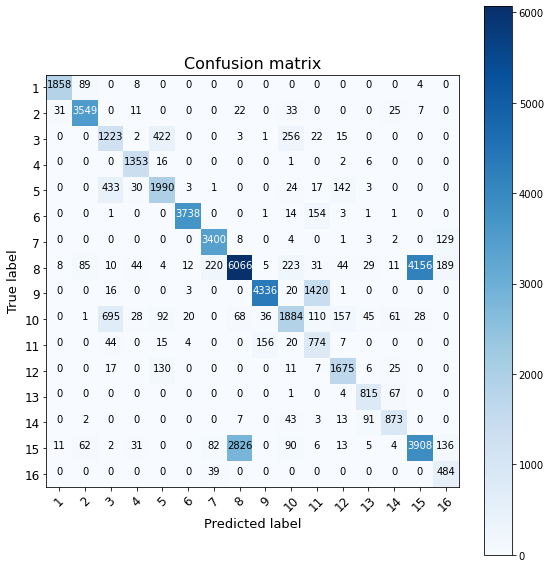

In [15]:
print('Overall Accuracy of RF with selected features: ' + "%.2f"  % (OA_RF*100) + '%')
plt.rcParams['figure.figsize'] = [8, 8]
f = plt.figure()
plot_confusion_matrix(CM_RF, classes_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)
plt.show()
plt.savefig(Rootoutput + os.path.sep + 'FeatSelect_RF' + '.eps', format='eps', dpi=1000)

##### RF with all features

In [16]:
[rf1, OA_RF_all, CM_RF_all, k, CR]= prediction(X_train, Y_train, X_test, Y_test, classes_names, selected_features = None)

Overall Accuracy of RF with all features: 87.93%
Confusion matrix


<Figure size 576x576 with 0 Axes>

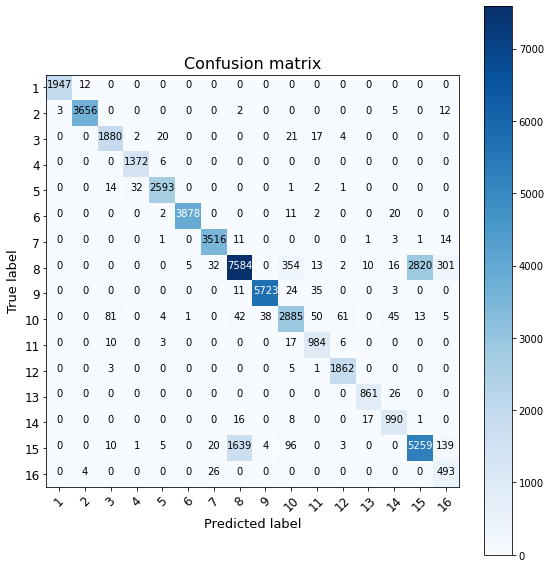

In [17]:
print('Overall Accuracy of RF with all features: ' + "%.2f"  % (OA_RF_all*100) + '%')
plt.rcParams['figure.figsize'] = [8, 8]
f = plt.figure()
plot_confusion_matrix(CM_RF_all, classes_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)
plt.show()

#### Classifiation maps:

In [18]:
Yimage_GRRF = classificationMap(final_grrf, X_total, Y_total, selected_features, nr, nc)
Yimage_RF = classificationMap(final_rf, X_total, Y_total, sel_RF, nr, nc)
Yimage_RF_all = classificationMap(rf, X_total, Y_total, [], nr, nc)

Y_total = Y_total.reshape((nr, nc))

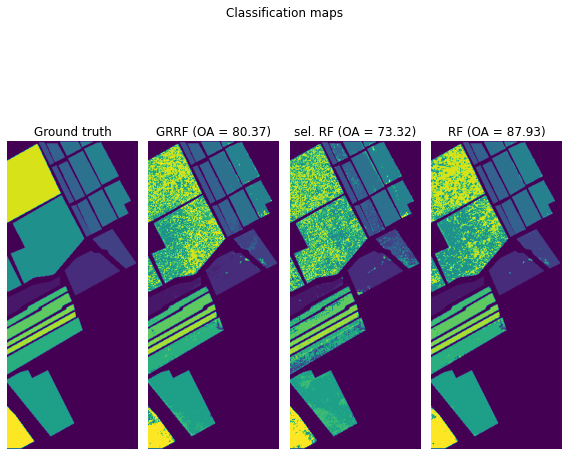

In [19]:
fig, axs = plt.subplots(1,4)
fig.tight_layout()
fig.suptitle('Classification maps')
axs[0].imshow(Y_total)
axs[0].axis('off')
axs[0].title.set_text('Ground truth')

axs[1].imshow(Yimage_GRRF)
axs[1].axis('off')
txt = 'GRRF (OA = {OA:.2f})'
axs[1].title.set_text(txt.format(OA = OA_GRRF*100))

axs[2].imshow(Yimage_RF)
axs[2].axis('off')
txt = 'sel. RF (OA = {OA:.2f})'
axs[2].title.set_text(txt.format(OA = OA_RF*100))

axs[3].imshow(Yimage_RF_all)
axs[3].axis('off')
txt = 'RF (OA = {OA:.2f})'
axs[3].title.set_text(txt.format(OA = OA_RF_all*100))

plt.show()